In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect, join
from sqlalchemy.sql import select

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Find out column names for measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find out column names for station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

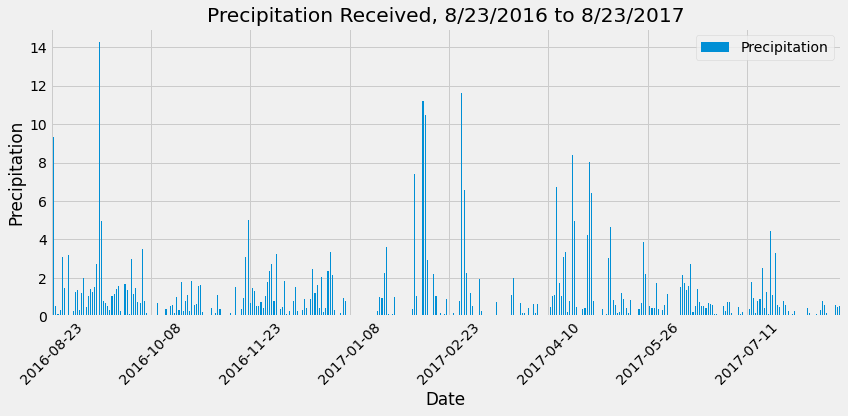

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
one_yr_ago = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
# prcp_data = session.query(measurement).join(station, station.station==measurement.station)\
#     .filter(measurement.date>=one_yr_ago).group_by(station.station).all()

prcp_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date>=one_yr_ago).all()
prcp_data

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(prcp_data)

# Drop null values
df = df.dropna()

# Sort the dataframe by date
df = df.sort_values('date')

# Rename columns
df = df.rename(columns={'date':"Date", 'prcp':'Precipitation'})

# set the index to the date column
df= df.set_index('Date')

# Group by date add up values to find total prcp per day
df = df.groupby('Date').sum()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='bar', figsize = (12,6), rot = 45)
plt.title('Precipitation Received, 8/23/2016 to 8/23/2017')
plt.ylabel('Precipitation')
plt.locator_params(axis='x', nbins=8)
plt.tight_layout()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.station).count()
station_count

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id of the most active station from the previous query, 

# Store the most active station
most_active = active_stations[0][0]

# calculate the lowest temperature recorded
lowest_temp = session.query(measurement.tobs).filter(measurement.station==most_active)\
    .order_by(measurement.tobs.asc()).first()[0]

lowest_temp

54.0

In [17]:
# Calculate the highest temperature recorded of the most active station
highest_temp = session.query(measurement.tobs).filter(measurement.station==most_active)\
    .order_by(measurement.tobs.desc()).first()[0]

highest_temp

85.0

In [18]:
# Average temperature of the most active station
avg_temp = session.query(func.avg(measurement.tobs))\
    .filter(measurement.station==most_active).scalar()
avg_temp

71.66378066378067

Text(0.5, 0, 'Temperature (F)')

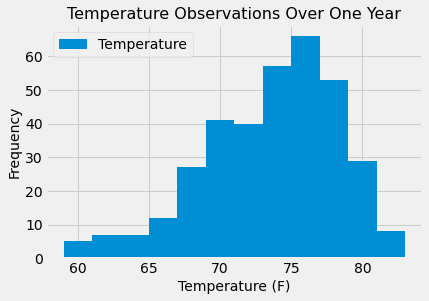

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tobs = session.query(measurement.tobs)\
    .filter(measurement.station==most_active).filter(measurement.date>=one_yr_ago).all()

# Create data frame
tobs_df = pd.DataFrame(station_tobs).rename(columns={'tobs':'Temperature'})

# Plot as histogram
tobs_df.plot.hist(bins=12)
plt.title('Temperature Observations Over One Year', size = 16)
plt.ylabel('Frequency', size=14)
plt.xlabel('Temperature (F)', size=14)

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs),
        func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# one_yr_ago = dt.date(2017,8,23)-dt.timedelta(days=365)
one_yr_ago = str(one_yr_ago)
last_date = last_date[0]
# print(last_date)
# one_yr_ago
last_date
# date = dt.datetime.strptime(one_yr_ago, "%Y-%m-%d")
# datetime.datetime.strptime("2013-1-25", '%Y-%m-%d').strftime('%m/%d/%y')
temp_summary = calc_temps(one_yr_ago, last_date)
# calc_temps('2016-08-23','2017-08-23')

[(58.0, 74.59058295964125, 87.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
